<a href="https://colab.research.google.com/github/JordanFoss/STAT3007_Project/blob/main/TimeDistributedCNN%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/

Cloning into 'STAT3007_Project'...
remote: Enumerating objects: 2367, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2367 (delta 0), reused 0 (delta 0), pack-reused 2364
Receiving objects: 100% (2367/2367), 326.25 MiB | 28.35 MiB/s, done.
Resolving deltas: 100% (552/552), done.
Checking out files: 100% (1900/1900), done.
/content/STAT3007_Project/STAT3007_Project/STAT3007_Project


In [40]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import scipy
import numpy as np
import librosa
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
import pandas as pd
import glob
from librosa import display

from IPython.display import Audio


In [41]:
# fourier transform
def spectral_decomposition(sample,sampling_rate, eps = 1e-14, title = ' title placeholder', visualise = False):
    frequencies, times, spectrogram = scipy.signal.spectrogram(sample,fs = sampling_rate)

    
    
    
    if visualise:
      specgram = plt.pcolormesh(times, frequencies, np.log(spectrogram + eps),shading = 'auto')
      plt.clim(-40, -5)
      
      plt.colorbar(specgram)
      #plt.imshow(np.log(spectrogram))
      plt.ylabel('Frequency [Hz]')
      plt.xlabel('Time [sec]')
      plt.title(title)
      plt.show()
    
    return frequencies, times, np.log(spectrogram+ eps)

In [42]:
# produce emotion label

# 0 - calm; 1 - happy; 2 - sad; 3 - angry; 4 - surprised
target_map = {'02':0,'03':1,'04':2,'05':3,'08':4}

def target_generation(file_name):
  labels = file_name.split('.')[0].split('-')
  emotion = labels[0]

  if emotion not in target_map:
    return None

  return target_map[emotion]

# Pre-Process

##Current Problem
The time steps for speech data is not the same.

proposed solution:
1. test data - no changes
2. training data - pad all the samples to max length. Since we want our network to be independent of audio length, we can do data augmentation to break them apart. (source https://arxiv.org/pdf/1607.02857.pdf)

3. must read: effect of padding on CNN and LSTM (https://arxiv.org/pdf/1903.07288.pdf)
 * Acoording to the paper, prepadding is good for LSTM and CNN. So we choose __pre-padding__ the samples

## Audio Slience Truncating
We observe that there is radio slience before and after the actual speech. So we have to truncate them all. We do this by truncating
1. all the time steps below a certain threshold before a certain time step
2. all the time steps after the last time step above the threshold.

Threshold: $10^{-3}$

Helper function at the end of this session

In [43]:
test_sample, test_rate = librosa.load('/content/STAT3007_Project/Audio_Speech_Actors_01-24/Female/Actor_08/02-02-01-02-08.wav', sr= None)

Text(0.5, 1.0, 'clean')

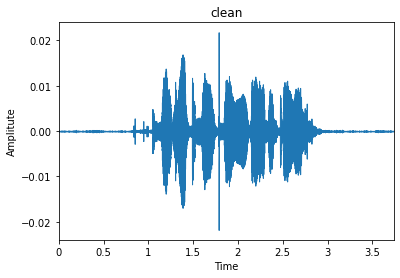

In [44]:
plt.figure()
display.waveplot(y = test_sample, sr = test_rate)
plt.ylabel('Amplitute')
plt.title('clean')

In [45]:
audio_start = np.where(abs(test_sample) > 1e-3)
audio_end = np.where(abs(test_sample) > 1e-3)

In [46]:
audio_start[0][0]

40058

In [47]:
audio_start[0][-1]

137038

Text(0.5, 1.0, 'clean')

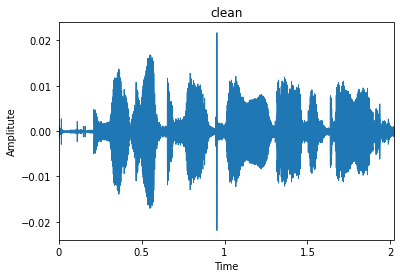

In [48]:
plt.figure()
display.waveplot(y = test_sample[40058:137038], sr = test_rate)
plt.ylabel('Amplitute')
plt.title('clean')

In [49]:
Audio(test_sample[40058:137038], rate = test_rate)

In [50]:
def truncate_silence(sample):
  speech = np.where(abs(sample) > 1e-3)

  start = speech[0][0]
  end = speech[0][-1]

  return sample[start:end+1]

## Padding

In [51]:
# find maximum and minimum duration
def find_min_max():

  min_time = 41241
  max_time = 0
  min_sample = 0
  max_sample = 0
  for folder_name in glob.glob('./Audio_Speech_Actors_01-24/*'):
    for actor_folder in glob.glob(folder_name + '/*'):
      for sample_path in glob.glob(actor_folder + '/*'):
        sample_name = sample_path.split('/')[-1]
        file_format = sample_name.split('.')[-1]

        # we want only audio files, selected emotions and strong intensity
        if file_format != 'wav' or sample_name[:2] not in target_map or sample_name[3:5] == '01':
          continue
        
        sample, sampling_rate = librosa.load(sample_path, sr = None)

        sample = truncate_silence(sample)

        sampling_time = sample.shape[0]/sampling_rate

        if sampling_time < min_time:
          min_time = sampling_time
          min_sample = sample.shape[0]
          min_file = sample_name

        if sampling_time > max_time:
          max_time = sampling_time
          max_sample = sample.shape[0]
          max_file = sample_name

  return min_time, max_time, min_sample, max_sample, min_file, max_file

In [52]:
min_time, max_time, min_sample, max_sample,min_file,max_file = find_min_max()


Now that we have the maximum duration of the dataset, we can start pre-padding

In [53]:
def pre_pad(samples, max_sample):
  sample_duration = samples.shape[0]

  num_to_pad = max_sample - sample_duration
  padded_sample = np.pad(samples,(num_to_pad,0),'constant', constant_values = 0)

  return padded_sample

let's inspect how the pre-pad works by choosing a random file and inspect the padded spectrogram

In [54]:
test_sample, test_rate = librosa.load('/content/STAT3007_Project/Audio_Speech_Actors_01-24/Female/Actor_08/02-02-01-02-08.wav', sr= None)

In [55]:
max_sample

211873

In [56]:
test_sample_tr = truncate_silence(test_sample)
test_sample_pad = pre_pad(test_sample_tr, max_sample)

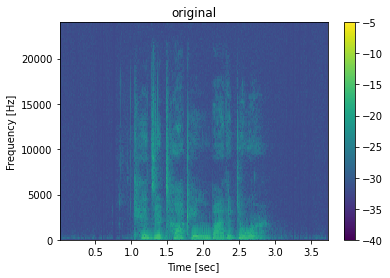

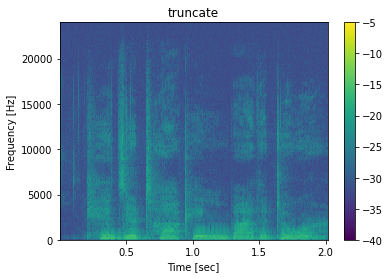

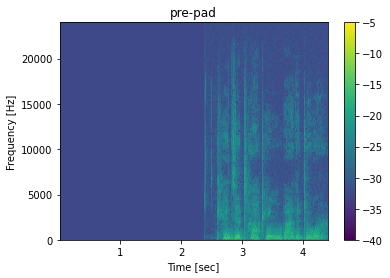

In [57]:
test_freq, test_times, test_spec = spectral_decomposition(test_sample,test_rate, visualise = True, title = 'original')
plt.figure()
test_freq, test_times, test_spec = spectral_decomposition(test_sample_tr,test_rate, visualise = True, title = 'truncate')
plt.figure()
test_freq, test_times, test_spec = spectral_decomposition(test_sample_pad,test_rate, visualise = True, title = 'pre-pad')

Apply padding and truncation on all the data

In [58]:
def load_samples(max_sample, padding = True, truncating = True):
  # load samples
  X = []
  y = []

  for folder_name in glob.glob('./Audio_Speech_Actors_01-24/*'):
    for actor_folder in glob.glob(folder_name + '/*'):
      for sample_path in glob.glob(actor_folder + '/*'):
        
        sample_name = sample_path.split('/')[-1]
        file_format = sample_name.split('.')[-1]

        if file_format != 'wav' or sample_name[:2] not in target_map or sample_name[3:5] == '01':
          continue

        sample, sampling_rate = librosa.load(sample_path, sr = None)
        
        truncated_sample = sample

        

        if truncating:
          truncated_sample = truncate_silence(sample)

        padded_sample = truncated_sample

        if padding:
          padded_sample = pre_pad(truncated_sample, max_sample)


        frequencies, times, spectrogram = spectral_decomposition(padded_sample, sampling_rate)
        
        target = target_generation(sample_name)

        if target != None:
          X.append(spectrogram)
          y.append(target)
  
  return X, y


In [59]:
X,y = load_samples(max_sample, padding = True, truncating = True)

## Clean-up data
1. Truncate X to be the proper size. detail below
2. vectorised y

In [60]:
def vectorise(y):
  '''
  Vectorise the digit label target to a binary vector
  Parameter:
  ----------
      y: torch.tensor
          The target vector of MNIST dataset

  Returns:
  --------
    vectorised_y: torch.tensor
        Vectorised version of y
  '''
  num_digits = 5

  one_hot_tensor = []
  for target in y:
    one_hot = np.array([0 for i in range(num_digits)])
    one_hot[target] = 1
    one_hot_tensor.append(one_hot)
  
  vectorised_y = torch.tensor(one_hot_tensor)

  return vectorised_y

In [61]:
# convert torch type
X = torch.tensor(X)

# (batch_size, channels, freq, time)
X = X.reshape(X.shape[0],1,X.shape[1],X.shape[2])

y = torch.tensor(y)

#one-hot y
#y = vectorise(y)

Since our convNet takes $129\times 129$ "image", we want to somewhat adjust our time length so that the convNet can iterate through the specotrgam over time completely (without overlap). 

This means that we want to make our input spectrogram to have timestep of a multiple of $129$

In [62]:
# first, let's consider truncating it to the nearest integer diviser
# this works because the original data has 0.5 second of radio slience before the actual audio.
truncate_multiple = X.shape[3] // 129

In [63]:
truncate_multiple

7

In [64]:
X.shape[3] - (129 * truncate_multiple)

42

In [65]:
# in fact, the length of the sample is only shortened by 0.0002 second as shown below,
# so shortening it eliminates only the radio slience
max_time - ((max_sample-truncate_multiple*129) /48000)

0.01881250000000012

### Dimension truncation
Now we implement the idea of truncating the data as outlined above

In [66]:
def truncate_sample(X, conv_input_size):
  new_time_size = (X.shape[3]//conv_input_size) * conv_input_size

  time_to_truncate = X.shape[3] - new_time_size

  return X[:,:,:,time_to_truncate:]


In [67]:
X = truncate_sample(X,129)

In [68]:
X.shape

torch.Size([480, 1, 129, 903])

# Architecture building

1. build a CNN
2. build a RNN embedded with CNN

Here, we are going to have 8 time steps in the RNN. In each time step, we take a $129\times 129$ truncated spectrogram as an input to the CNN, then the flattened output of CNN will be the input of RNN.

## CNN

In [69]:
# convolutional net

# input: 129x129
#output: 30x30 for 32 filters
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.flatten = nn.Flatten()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            nn.Conv2d(32, 32, kernel_size = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
        )

    def forward(self, x, inspect_feature = False):

      conv_x = self.conv(x)
      conv_x_flat  = self.flatten(conv_x)
      if inspect_feature:
        return conv_x
      return conv_x_flat

In [70]:
# example usage
CNN = ConvNet()
cnn_out = CNN(-X[:30,:,:,:129], inspect_feature = True)

In [71]:
cnn_out.shape

torch.Size([30, 32, 30, 30])

This means that we have a total of $30\times 30\times 32$ neurons as output of CNN

## RNN

In [72]:
# RNN combined with CNN
class LRCN(nn.Module):
    def __init__(self, num_inputs, CNN):
        super(LRCN, self).__init__()

        self.cnn = CNN
        self.lstm_layers = nn.LSTM(num_inputs,100,num_layers = 2)
        self.linear = nn.Sequential(nn.Linear(100, 5)
                                    )

    def forward(self, x, step_size, use_cuda = False):

      if use_cuda:
        h_t = torch.zeros(2,x.shape[0] ,100, dtype=torch.float).to(x.device)
        c_t = torch.zeros(2,x.shape[0], 100, dtype=torch.float).to(x.device)

      else:
        h_t = torch.zeros(2,x.shape[0], 100, dtype=torch.float)
        c_t = torch.zeros(2,x.shape[0], 100, dtype=torch.float)

      current_time = 0
      for look_ahead_time in range(step_size,x.shape[3]+1, step_size):

        x_t = x[:,:,:,current_time:look_ahead_time]
        current_time = look_ahead_time
        conv_x_flat = self.cnn(x_t)

        conv_x_flat = conv_x_flat.reshape(1,conv_x_flat.shape[0],conv_x_flat.shape[1])

        output, (h_t, c_t) = self.lstm_layers(conv_x_flat, (h_t, c_t))

      decision_vec = self.linear(output[0])
      return decision_vec

In [73]:
# Example usage
CNN = ConvNet()
num_inputs = 32*30*30
step_size = 129

ConvLSTM = LRCN(num_inputs, CNN)

batch = -X[:30]

output = ConvLSTM(batch,129)

In [74]:
output.shape

torch.Size([30, 5])

In [75]:
output[0]

tensor([-0.1270,  0.0782,  0.0342,  0.1382, -0.0778], grad_fn=<SelectBackward>)

## Combining CNN and RNN
It seems like the model would not train if i predefined a CNN model then pass it as a parameter of to the RNN. So I am going to define a complete new CNN inside the RNN instead.

In [76]:
class Conv_LSTM(nn.Module):
    def __init__(self):
        super(Conv_LSTM, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            nn.Conv2d(32, 32, kernel_size = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
        )

        self.flatten = nn.Flatten()


        self.lstm_layers = nn.LSTM(32*30*30,500,num_layers = 2)
        self.linear = nn.Sequential(nn.Linear(500, 5, bias = True)
        )

    def forward(self, x, step_size = 129, use_cuda = False):

      if use_cuda:
        h_t = torch.zeros(2,x.shape[0] ,500, dtype=torch.float).to(x.device)
        c_t = torch.zeros(2,x.shape[0], 500, dtype=torch.float).to(x.device)

      else:
        h_t = torch.zeros(2,x.shape[0], 500, dtype=torch.float)
        c_t = torch.zeros(2,x.shape[0], 500, dtype=torch.float)

      current_time = 0
      for look_ahead_time in range(step_size,x.shape[3]+1, step_size):

        x_t = x[:,:,:,current_time:look_ahead_time]
        current_time = look_ahead_time
        conv_x = self.cnn(x_t)
        conv_x_flat = self.flatten(conv_x)

        conv_x_flat = conv_x_flat.reshape(1,conv_x_flat.shape[0],conv_x_flat.shape[1])

        output, (h_t, c_t) = self.lstm_layers(conv_x_flat, (h_t, c_t))

      decision_vec = self.linear(output[0])
      return decision_vec

In [77]:
# Example usage
step_size = 129

conv_lstm = Conv_LSTM()

batch = -X[:30]

output = conv_lstm(batch)

In [78]:
c = conv_lstm.parameters()  
s = ConvLSTM.parameters()

In [79]:
for param in c:
  print(param.data.shape)

torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([2000, 28800])
torch.Size([2000, 500])
torch.Size([2000])
torch.Size([2000])
torch.Size([2000, 500])
torch.Size([2000, 500])
torch.Size([2000])
torch.Size([2000])
torch.Size([5, 500])
torch.Size([5])


In [80]:
for param in s:
  print(param.data.shape)

torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([400, 28800])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([400, 100])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([5, 100])
torch.Size([5])


In [81]:
output.shape

torch.Size([30, 5])

In [82]:
output[0]

tensor([ 0.1314,  0.0242, -0.0883, -0.0319, -0.0496], grad_fn=<SelectBackward>)

## Note
1. choose CNN+RNN combination if we want to train CNN from stratch
2. choose RNN and pass CNN as a parameter if we have a pretrained model (parametric CNN does not learn)

# Training
Now we attempt to train on some datasets and see how it performs.
* Loss function: quadratic loss
* learning rate = 0.01

In [83]:
class DatasetWrapper(Dataset):
  def __init__(self, X, y):
    self.X, self.y = X, y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]
  
  def change_type(self, dtype):

    return DatasetWrapper(self.X.type(dtype),self.y.type(dtype))
  
  def dataset(self):
    return DatasetWrapper(self.X,self.y)
  
  def get_data(self):
    return self.X, self.y

In [84]:
def train_model(data, net, loss, nepoch, step_size = 129 ,lr = 0.01, batch_size = -1, use_cuda = False):
  


  # appropriate data type for CPU or GPU
  device = None
  if use_cuda and torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda")
    net = net.to(device)
  else:
    dtype = torch.FloatTensor

  optimizer = optim.SGD(net.parameters(), lr = lr)
  data = data.dataset.change_type(dtype)

  if batch_size == -1:
    data_loader = DataLoader(data,
                         batch_size = num_samples, shuffle = True)
  
  else:
    data_loader = DataLoader(data,
                             batch_size = batch_size, shuffle = True)
    
  for epoch in range(nepoch):
     for X_batch, y_batch in data_loader:
      y_batch = y_batch.type(torch.LongTensor)
      if use_cuda and device != None:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_batch = y_batch.type(torch.cuda.LongTensor)

      optimizer.zero_grad()

      # since all our values are negative, we convert them to positive
      pred = net(-X_batch, step_size, use_cuda = use_cuda)
      Rn = loss(pred, y_batch)
      Rn.backward()
      optimizer.step()
     print('epoch:', epoch)
     print('loss:',Rn.item())
     print('------------')
  
  return net

In [85]:
def quadratic_loss(f,Y):
  SE = torch.square(torch.norm(f - Y,dim = 1, p =2))
  MSE = torch.mean(SE)
  return MSE


spectro_data = DatasetWrapper(X,y)
train_size = int(X.shape[0] * 0.9)
test_size = X.shape[0] - train_size

loss = nn.CrossEntropyLoss()

data_test, data_train = random_split(spectro_data,[test_size,train_size], generator = torch.Generator().manual_seed(10))

conv_lstm = Conv_LSTM()

nepoch = 100
batch_size = 30
trained_net = train_model(data_train,conv_lstm, loss, nepoch = nepoch, step_size = 129,lr = 0.01, batch_size = batch_size, use_cuda = True)

epoch: 0
loss: 1.6092089414596558
------------
epoch: 1
loss: 1.5948535203933716
------------
epoch: 2
loss: 1.6027796268463135
------------
epoch: 3
loss: 1.5962878465652466
------------
epoch: 4
loss: 1.5936176776885986
------------
epoch: 5
loss: 1.5971447229385376
------------
epoch: 6
loss: 1.5899899005889893
------------
epoch: 7
loss: 1.5854737758636475
------------
epoch: 8
loss: 1.5970323085784912
------------
epoch: 9
loss: 1.5819886922836304
------------
epoch: 10
loss: 1.5950465202331543
------------
epoch: 11
loss: 1.6034457683563232
------------
epoch: 12
loss: 1.584102988243103
------------
epoch: 13
loss: 1.6000456809997559
------------
epoch: 14
loss: 1.5850300788879395
------------
epoch: 15
loss: 1.5729013681411743
------------
epoch: 16
loss: 1.5769407749176025
------------
epoch: 17
loss: 1.5919047594070435
------------
epoch: 18
loss: 1.5492347478866577
------------
epoch: 19
loss: 1.5765377283096313
------------
epoch: 20
loss: 1.5870819091796875
------------
epo

## Training problem
performance not increased.

possible solution:
1. nomalisation
2. transfer learning (https://www.frontiersin.org/articles/10.3389/fcomp.2020.00014/full)
3. RGB decomposition (https://www.frontiersin.org/articles/10.3389/fcomp.2020.00014/full)

In [86]:
X_test, y_test = data_test.dataset.get_data()
X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))

In [87]:
trained_net = trained_net.to(torch.device('cpu'))

In [88]:
y_pred = trained_net(-X_test[:10])

In [89]:
nn.functional.sigmoid(y_pred)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[0.5014, 0.5124, 0.5127, 0.5134, 0.5087],
        [0.5047, 0.5118, 0.5138, 0.5075, 0.5082],
        [0.5099, 0.5099, 0.5172, 0.5009, 0.5078],
        [0.5147, 0.5078, 0.5195, 0.4959, 0.5069],
        [0.4970, 0.5138, 0.5107, 0.5171, 0.5083],
        [0.5010, 0.5127, 0.5125, 0.5119, 0.5088],
        [0.5129, 0.5087, 0.5184, 0.4968, 0.5073],
        [0.5093, 0.5100, 0.5159, 0.5038, 0.5069],
        [0.5020, 0.5119, 0.5134, 0.5098, 0.5080],
        [0.5025, 0.5128, 0.5133, 0.5095, 0.5091]], grad_fn=<SigmoidBackward>)

In [90]:
y_test[:10]

tensor([4, 1, 2, 0, 4, 4, 2, 3, 1, 4])